In [32]:
%pip install pyflakes
%pip install tiktoken
%pip install pandas
%pip install matplotlib
%pip install numpy
%pip install seaborn
%pip install scikit-learning
%pip install tqdm
%pip install pyarrow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement scikit-learning (from versions: none)
ERROR: No matching distribution found for scikit-learning
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [33]:
import sys
import tiktoken
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io, re, random, tokenize, keyword, string
from pyflakes.api import check as validate_code
from pyflakes.reporter import Reporter as LogHandler
from io import StringIO as MemoryStream
from tqdm import tqdm as progress_bar

from google.colab import drive
drive.mount('/content/drive')

df_alpaca = pd.read_parquet('/content/drive/MyDrive/Thesis/Data/python_code_instructions_18k_alpaca.parquet', engine='pyarrow')
df_alpaca.head()
def check_syntax(code):
    original_stdout, original_stderr = sys.stdout, sys.stderr
    try:
        sys.stdout, sys.stderr = MemoryStream(), MemoryStream()
        return validate_code(code, filename='', reporter=LogHandler(sys.stdout, sys.stderr)) == 0
    finally:
        sys.stdout, sys.stderr = original_stdout, original_stderr

error_indices = [i for i in progress_bar(range(len(df_alpaca))) if not check_syntax(df_alpaca['output'][i])]
code=df_alpaca
syntactic_error = check_syntax(code)


100%|██████████| 18612/18612 [00:05<00:00, 3121.68it/s]


Total tokens: 142996
Avg tokens: 35.66


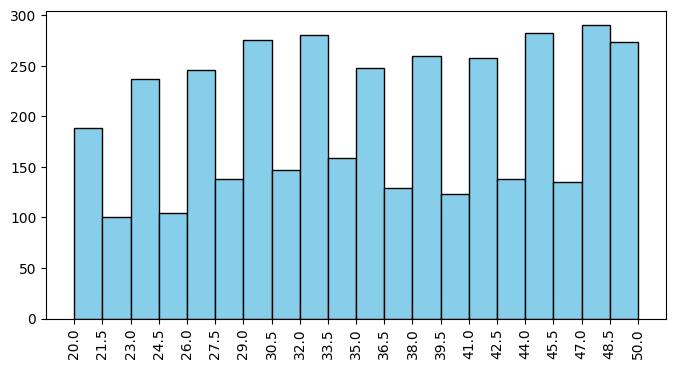

,instruction,input,output,prompt
29,Write a function in Python to calculate the su...,,def sum_digits(num):\n total = 0\n while...,Below is an instruction that describes a task....
23,Create a Python neural network model that take...,"[10, 10.4, 10.5, 10.6, 10.7, 10.9, 11]",import numpy as np\nimport tensorflow as tf\n\...,Below is an instruction that describes a task....
48,Write a Python program to generate a Markov ch...,Alice was beginning to get very tired of sitti...,import random\n\ndef generateMarkov(text):\n ...,Below is an instruction that describes a task....
22,Write a Python program to query Twitter to get...,username: @elonmusk,import tweepy\n\n# Authenticate to Twitter\nau...,Below is an instruction that describes a task....
47,Create a Python program to calculate the avera...,,nums = []\nfor i in range(5):\n nums.append...,Below is an instruction that describes a task....


In [34]:
valid_indices = [idx for idx in df_alpaca.index if idx not in set(error_indices)]
token_counts = [len(tiktoken.get_encoding('cl100k_base').encode(df_alpaca['output'][idx])) for idx in valid_indices]

filtered_idx = [(idx, cnt) for idx, cnt in zip(valid_indices, token_counts) if 20 <= cnt <= 50]

filtered_counts = [cnt for _, cnt in filtered_idx]

print(f"Total tokens: {sum(filtered_counts)}\nAvg tokens: {sum(filtered_counts) / len(filtered_counts):.2f}")

bins = min(max(filtered_counts) - min(filtered_counts) + 1, 20)
plt.figure(figsize=(8, 4))
plt.hist(filtered_counts, bins=bins, color='skyblue', edgecolor='black', align='mid')
plt.xticks(np.linspace(min(filtered_counts), max(filtered_counts), bins + 1), rotation='vertical')
plt.show()
df_alpa_filter = df_alpaca.iloc[filtered_counts].copy(deep=True)
len(df_alpa_filter)
df_alpa_filter.head()

In [35]:
import re
import tokenize
import keyword
import io
import random

# Check for specific patterns and return modified code if it passes the syntax check
def check_patterns(code, pattern, replace=None):
    lines = code.split('\n')
    for i, line in enumerate(lines):
        match = re.search(pattern, line)
        if match:
            new_line = replace(line, match) if replace else line[:match.end()-1] + line[match.end():]
            temp_code = '\n'.join(lines[:i] + [new_line] + lines[i+1:])
            if not check_syntax(temp_code):  # Ensure code still works after modification
                return True, temp_code, i + 1
    return False, code, -1

# Missing colon error detection and correction
def miss_colon(code):
    return check_patterns(code, r"^\s*(def|if|else|for|while|with|try|except|finally)\b.*:$")

# Missing parenthesis error detection and correction
def miss_paren(code):
    return check_patterns(code, r"\)", lambda l, m: l[:m.start()] + l[m.start()+1:])

# Missing quotation mark error detection and correction
def miss_quote(code):
    return check_patterns(code, r"[\'\"]", lambda l, m: l[:m.start()] + l[m.start()+1:])

# Missing comma error detection and correction
def miss_comma(code):
    return check_patterns(code, r",", lambda l, m: l[:m.start()] + l[m.start()+1:])

# Mismatched quotation error detection and correction
def mismatch_quote(code):
    return check_patterns(code, r"[\'\"]", lambda l, m: l[:m.start()] + ('"' if m.group() == "'" else "'") + l[m.start()+1:])

# Mismatched bracket error detection and correction
def mismatch_bracket(code):
    return check_patterns(code, r"[)\]}]", lambda l, m: l[:m.start()] + random.choice({')':['}', ']'], ']':['}', ')'], '}':[')', ']']}[m.group()]) + l[m.start()+1:])

# Extract imports to prevent changing valid identifiers into keywords
def extract_imports(code):
    imported = []
    capture = False  # Ensure 'capture' is initialized here
    stream = io.BytesIO(code.encode('utf-8'))
    for toktype, tokval, _, _, _ in tokenize.tokenize(stream.readline):
        if toktype == tokenize.NAME and tokval in ['import', 'from', 'as']:
            capture = True
        elif capture and toktype == tokenize.NAME:
            imported.append(tokval)
        capture = False if toktype in [tokenize.NEWLINE, tokenize.NL, tokenize.ENDMARKER] else capture
    return imported

# Keyword as identifier detection and correction
def kw_as_ident(code):
    keywords = keyword.kwlist
    stream = io.BytesIO(code.encode('utf-8'))
    tokens = list(tokenize.tokenize(stream.readline))
    imported = extract_imports(code)  # Extract imports to avoid changing them
    identifiers = [(t.start[0], t.start[1], t.string) for t in tokens if t.type == tokenize.NAME and not keyword.iskeyword(t.string) and t.string not in imported]
    
    for line, start, ident in identifiers:
        valid_kw = [kw for kw in keywords if kw != ident]
        if valid_kw:
            rand_kw = random.choice(valid_kw)  # Replace with a random keyword
            lines = code.split('\n')
            new_line = lines[line-1][:start] + rand_kw + lines[line-1][start+len(ident):]
            new_code = '\n'.join(lines[:line-1] + [new_line] + lines[line:])
            if not check_syntax(new_code):  # Ensure syntax is correct after modification
                return True, new_code, line
    return False, code, -1


In [36]:
df_alpa_filter = df_alpa_filter.reset_index(drop=True)
error_indices = []  # list of indices of code snippets with errors          
for i in progress_bar(range(len(df_alpa_filter))):
    code = df_alpa_filter['output'][i]
    for check in [miss_colon, miss_paren, miss_quote, miss_comma, mismatch_quote, mismatch_bracket, kw_as_ident]:
        error, code, line = check(code)
        if error:
            error_indices.append((i, line))
            break

100%|██████████| 4010/4010 [00:00<00:00, 47787.13it/s]


In [37]:
# Ensure the function names in the transformations match the actual function names
transformations = [
    ('miss_colon', 'output_miss_colon', 'bugline_no_miss_colon'),
    ('miss_paren', 'output_miss_paren', 'bugline_no_miss_paren'),
    ('miss_quote', 'output_miss_quote', 'bugline_no_miss_quote'),
    ('miss_comma', 'output_miss_comma', 'bugline_no_miss_comma'),
    ('mismatch_quote', 'output_mismatch_quote', 'bugline_no_mismatch_quote'),
    ('mismatch_bracket', 'output_mismatch_bracket', 'bugline_no_mismatch_bracket'),
    ('kw_as_ident', 'output_kw_as_ident', 'bugline_no_kw_as_ident')
]

# Apply transformations in a loop
for func_name, output_col, line_col in transformations:
    # Apply the function and unpack the results into 'modified', 'new_code', 'line_number'
    df_alpa_filter[['modified', 'new_code', 'line_number']] = df_alpa_filter['output'].apply(lambda x: globals()[func_name](x)).apply(pd.Series)

    # Update the respective columns if modifications were made
    df_alpa_filter.loc[df_alpa_filter['modified'], output_col] = df_alpa_filter['new_code']
    df_alpa_filter.loc[df_alpa_filter['modified'], line_col] = df_alpa_filter['line_number']

    # Drop temporary columns after processing
    df_alpa_filter.drop(['modified', 'new_code', 'line_number'], axis=1, inplace=True)



In [39]:
df_alpa_filter.drop(['instruction', 'input', 'prompt'], axis=1, inplace=True)

In [41]:
# Fill NaN values for string columns
str_columns = [
    'output_miss_colon', 'output_miss_paren', 'output_miss_quote',
    'output_miss_comma', 'output_mismatch_quote', 'output_mismatch_bracket',
    'output_kw_as_ident'
]
df_alpa_filter[str_columns] = df_alpa_filter[str_columns].fillna('').astype(str)

# Fill NaN values for integer columns
int_columns = [
    'bugline_no_miss_colon', 'bugline_no_miss_paren',
    'bugline_no_miss_quote', 'bugline_no_miss_comma',
    'bugline_no_mismatch_quote', 'bugline_no_mismatch_bracket',
    'bugline_no_kw_as_ident'
]
df_alpa_filter[int_columns] = df_alpa_filter[int_columns].fillna(-1).astype(int)


In [44]:

df_alpa_filter.head(10)

,output,output_miss_colon,bugline_no_miss_colon,output_miss_paren,bugline_no_miss_paren,output_miss_quote,bugline_no_miss_quote,output_miss_comma,bugline_no_miss_comma,output_mismatch_quote,bugline_no_mismatch_quote,output_mismatch_bracket,bugline_no_mismatch_bracket,output_kw_as_ident,bugline_no_kw_as_ident
0,def sum_digits(num):\n total = 0\n while...,def sum_digits(num)\n total = 0\n while ...,1,def sum_digits(num:\n total = 0\n while ...,1,,-1,,-1,,-1,def sum_digits(num]:\n total = 0\n while...,1,def or(num):\n total = 0\n while num > 0...,1
1,import numpy as np\nimport tensorflow as tf\n\...,import numpy as np\nimport tensorflow as tf\n\...,4,import numpy as np\nimport tensorflow as tf\n\...,4,import numpy as np\nimport tensorflow as tf\n\...,6,import numpy as np\nimport tensorflow as tf\n\...,6,import numpy as np\nimport tensorflow as tf\n\...,6,import numpy as np\nimport tensorflow as tf\n\...,4,import numpy as np\nimport tensorflow as tf\n\...,4
2,import random\n\ndef generateMarkov(text):\n ...,import random\n\ndef generateMarkov(text)\n w...,3,import random\n\ndef generateMarkov(text:\n w...,3,import random\n\ndef generateMarkov(text):\n ...,4,import random\n\ndef generateMarkov(text):\n ...,25,import random\n\ndef generateMarkov(text):\n ...,4,import random\n\ndef generateMarkov(text}:\n ...,3,import random\n\ndef True(text):\n words = te...,3
3,import tweepy\n\n# Authenticate to Twitter\nau...,import tweepy\n\n# Authenticate to Twitter\nau...,12,import tweepy\n\n# Authenticate to Twitter\nau...,4,import tweepy\n\n# Authenticate to Twitter\nau...,4,,-1,import tweepy\n\n# Authenticate to Twitter\nau...,4,import tweepy\n\n# Authenticate to Twitter\nau...,4,import tweepy\n\n# Authenticate to Twitter\nan...,4
4,nums = []\nfor i in range(5):\n nums.append...,nums = []\nfor i in range(5)\n nums.append(...,2,nums = []\nfor i in range(5:\n nums.append(...,2,nums = []\nfor i in range(5):\n nums.append...,3,nums = []\nfor i in range(5):\n nums.append...,9,nums = []\nfor i in range(5):\n nums.append...,3,nums = [}\nfor i in range(5):\n nums.append...,1,not = []\nfor i in range(5):\n nums.append(...,1
5,"even_numbers = [i for i in range(1, 21) if i %...",,-1,"even_numbers = [i for i in range(1, 21 if i % ...",1,,-1,even_numbers = [i for i in range(1 21) if i % ...,1,,-1,"even_numbers = [i for i in range(1, 21] if i %...",1,"return = [i for i in range(1, 21) if i % 2 == 0]",1
6,"string1 = ""Hello""\nstring2 = ""World""\n\nprint(...",,-1,"string1 = ""Hello""\nstring2 = ""World""\n\nprint(...",4,"string1 = Hello""\nstring2 = ""World""\n\nprint(s...",1,,-1,"string1 = 'Hello""\nstring2 = ""World""\n\nprint(...",1,"string1 = ""Hello""\nstring2 = ""World""\n\nprint(...",4,"or = ""Hello""\nstring2 = ""World""\n\nprint(strin...",1
7,# This program is to understand recursion in P...,# This program is to understand recursion in P...,4,# This program is to understand recursion in P...,4,# This program is to understand recursion in P...,12,# This program is to understand recursion in P...,12,# This program is to understand recursion in P...,12,# This program is to understand recursion in P...,4,# This program is to understand recursion in P...,4
8,"myArray = [float(i) for i in range(0,11)]",,-1,"myArray = [float(i for i in range(0,11)]",1,,-1,myArray = [float(i) for i in range(011)],1,,-1,"myArray = [float(i} for i in range(0,11)]",1,"False = [float(i) for i in range(0,11)]",1
9,"import hashlib\n\ndef encrypt(message, key):\n...","import hashlib\n\ndef encrypt(message, key)\n ...",3,"import hashlib\n\ndef encrypt(message, key:\n ...",3,"import hashlib\n\ndef encrypt(message, key):\n...",4,import hashlib\n\ndef encrypt(message key):\n ...,3,"import hashlib\n\ndef encrypt(message, key):\n...",4,"import hashlib\n\ndef encrypt(message, key}:\n...",3,"import hashlib\n\ndef elif(message, key):\n ...",3


In [ ]:
from google.colab import files

df_alpa_filter.to_csv('/content/drive/MyDrive/Thesis/Data/dbs.csv', index=False)
files.download('/content/drive/MyDrive/Thesis/Data/dbs.csv')